# Example of a single spectrum fit.

## First step: extracting and viewing the spectrum

In [1]:
# inline plotting for jupyter notebook. Do not put this line in a real python script.
%matplotlib inline

In [2]:
# import base class for the manipulation of a SITELLE spectral cube: HDFCube
from orcs.core import HDFCube
import pylab as pl

In [3]:
# load spectral cube
cube = HDFCube('/home/thomas/M31_SN3.merged.cm1.1.0.hdf5')

17-07-24|17:34:34 # HDFCube.__init__ > Data shape : (2048, 2064, 840)
17-07-24|17:34:34 # HDFCube.__init__ > Cube is in WAVENUMBER (cm-1)
17-07-24|17:34:34 # HDFCube.__init__ > Cube is CALIBRATED


17-07-24|17:34:35 # HDFCube._extract_spectrum_from_region > Number of integrated pixels: 13
 [==========] [100%] [completed in 0.092 s]                                   
Init of the parallel processing server with 4 threads
 [==========] [100%] [completed in 0.421 s]                                   


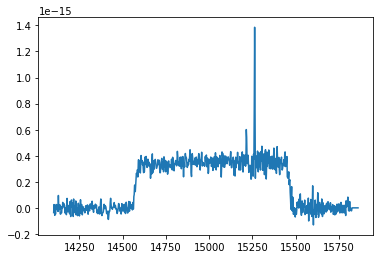

In [4]:
# extract and plot a spectrum at x=919 y=893 integrated over a radius of 2 pixels
axis, spectrum = cube.extract_spectrum(919, 893, 2)
pl.plot(axis, spectrum)

## Second step: fitting the spectrum

* The emission lines to fit are passed by name (their wavenumber, in cm-1, could also be given directly). 
  Remember that:
  
  $\sigma [\text{cm}^{-1}] = \frac{1e7}{\lambda [\text{nm}]}$
  
  
  
* The line model is `gaussian` by default. Here we use the more realistic model of a cardinal sinus convoluted with a gaussian `sincgauss`:
  
  `fmodel = 'sincgauss'`


* The velocity of the lines is -513 km/s. It is passed with the argument:

  `pos_cov = -513`

  The velocity is considered as a covarying parameter. By default all the lines are considered to share the same velocity, i.e. they all have the same covarying group. That's why the fitted velocity is the same for both lines.


* The broadening is considered to be a free parameter by default. It can be different for each line.


In [5]:
axis, spectrum, fit_res = cube.fit_lines_in_spectrum(919, 893, 2, ['Halpha', '[NII]6583'],
                                                     fmodel='sincgauss',
                                                     pos_cov=-513)
print '\n===== Results ======'
print 'Velocity: ', fit_res['velocity_gvar']
print 'Broadening: ', fit_res['broadening_gvar'] 
print 'Flux: ', fit_res['flux_gvar'] 
print '===================='

17-07-24|17:34:39 # HDFCube._extract_spectrum_from_region > Number of integrated pixels: 13
 [==========] [100%] [completed in 0.011 s]                                   
Init of the parallel processing server with 4 threads
 [==========] [100%] [completed in 0.442 s]                                   
SNR GUESS None

===== Results ======
Velocity:  [-506.4(1.3) -506.4(1.3)]
Broadening:  [25.7(1.7) 27.5(6.5)]
Flux:  [1.676(88)e-15 4.53(92)e-16]


### Ungroup the velocity parameter

We can ungroup the velocity of the emission lines by giving each line a unique group label. We can set:
  
  `pos_def=['1', '2']`
  
I this case the measured velocity must be different for both lines. But the precision will also be worsen.


In [6]:
axis, spectrum, fit_res = cube.fit_lines_in_spectrum(919, 893, 2, ['Halpha', '[NII]6583'],
                                                     fmodel='sincgauss',
                                                     pos_cov=-513,
                                                     pos_def=['1', '2'])
print '\n===== Results ======'
print 'Velocity: ', fit_res['velocity_gvar']
print 'Broadening: ', fit_res['broadening_gvar'] 
print 'Flux: ', fit_res['flux_gvar'] 
print '===================='

17-07-24|17:34:47 # HDFCube._extract_spectrum_from_region > Number of integrated pixels: 13
 [==========] [100%] [completed in 0.018 s]                                   
Init of the parallel processing server with 4 threads
 [==========] [100%] [completed in 0.437 s]                                   
SNR GUESS None

===== Results ======
Velocity:  [-506.0(1.3) -512.6(5.3)]
Broadening:  [25.7(1.7) 27.8(6.4)]
Flux:  [1.677(88)e-15 4.60(93)e-16]


### Group the broadening parameter

We can group the broadening parameter of the emission lines by giving the same group label to the lines. We can set:
  
  `sigma_def=['1', '1']`
  
I this case the measured broadening will be the same for both lines and the precision of the estimations are better.

In [7]:
axis, spectrum, fit_res = cube.fit_lines_in_spectrum(
    919, 893, 2, ['Halpha', '[NII]6583'],
    fmodel='sincgauss',
    pos_cov=-513,
    pos_def=['1', '1'],
    sigma_def=['1', '1'])
print '\n===== Results ======'
print 'Velocity: ', fit_res['velocity_gvar']
print 'Broadening: ', fit_res['broadening_gvar'] 
print 'Flux: ', fit_res['flux_gvar'] 
print '===================='

17-07-24|17:34:52 # HDFCube._extract_spectrum_from_region > Number of integrated pixels: 13
 [==========] [100%] [completed in 0.018 s]                                   
Init of the parallel processing server with 4 threads
 [==========] [100%] [completed in 0.415 s]                                   
SNR GUESS None

===== Results ======
Velocity:  [-506.5(1.3) -506.5(1.3)]
Broadening:  [25.8(1.6) 25.8(1.6)]
Flux:  [1.680(86)e-15 4.40(59)e-16]


### Plotting the result

(14500, 15500)

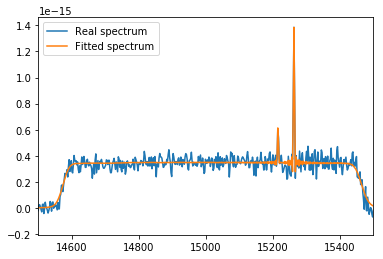

In [8]:
pl.plot(axis, spectrum, label='Real spectrum')
pl.plot(axis, fit_res['fitted_vector'], label='Fitted spectrum')
pl.legend()
pl.xlim((14500, 15500))

### Model with no filter

The filter model can be removed but the range over which the fit is made must be limited to the filter bandpass. This is made transparently by setting the option

`nofilter = True`


17-07-24|17:34:57 # HDFCube._extract_spectrum_from_region > Number of integrated pixels: 13
 [==========] [100%] [completed in 0.012 s]                                   
Init of the parallel processing server with 4 threads
 [==========] [100%] [completed in 0.430 s]                                   
SNR GUESS None

===== Results ======
Velocity:  [-506.4(1.5) -506.4(1.5)]
Broadening:  [26.1(1.8) 26.1(1.8)]
Flux:  [1.673(98)e-15 4.46(67)e-16]


(14500, 15500)

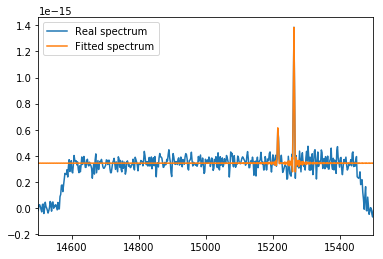

In [9]:
axis, spectrum, fit_res = cube.fit_lines_in_spectrum(
    919, 893, 2, ['Halpha', '[NII]6583'],
    fmodel='sincgauss',
    pos_cov=-513,
    pos_def=['1', '1'],
    sigma_def=['1', '1'],
    nofilter=True)
print '\n===== Results ======'
print 'Velocity: ', fit_res['velocity_gvar']
print 'Broadening: ', fit_res['broadening_gvar'] 
print 'Flux: ', fit_res['flux_gvar'] 
print '===================='
pl.plot(axis, spectrum, label='Real spectrum')
pl.plot(axis, fit_res['fitted_vector'], label='Fitted spectrum')
pl.legend()
pl.xlim((14500, 15500))